In [4]:
# various import statements
import os
import sklearn
from sklearn import cluster
import pandas as pd
import scanpy as sc
import scvi
import inspect
import tqdm
import numpy as np
from collections import defaultdict
import torch
import torch.nn as nn
from torch.nn.functional import softplus, softmax
from torch.distributions import constraints
import seaborn
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.optim
from pyro.infer import SVI
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [3]:
retina_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/shekar_retina'
rfiles=os.listdir(retina_path)
adatas={}
for f in rfiles:
    print(f)
    if not f in adatas.keys() and '.csv' in f:
        adata=sc.read_csv(os.path.join(retina_path,f)).T
        adata.obs['file']=f
        adatas[f]=adata

species_names = [re.search(r'_(\w+)_count_mat', filename).group(1) for filename in adatas.keys()]
keydict=dict(zip(adatas.keys(),species_names))
for k in adatas.keys():
    adatas[k].obs['species']=keydict[k]

GSE118852_Macaque_count_mat_M2perMixed.csv.gz
GSE118546_Macaque_count_mat_M4fovea.csv.gz
GSE118852_Macaque_count_mat_M4PerCD73.csv.gz
GSE237209_Pig_count_mat.csv.gz
GSE237204_Human_count_mat_2.csv.gz
GSE237203_Ferret_count_mat.csv.gz
GSE237204_Human_count_mat_1.csv.gz
GSE118852_Macaque_count_mat_M2PerCD73.csv.gz
GSE237214_Zebrafish_count_mat.csv.gz
GSE133382_Mouse_count_mat.csv.gz
GSE237204_Human_count_mat_3.csv.gz
GSE237206_Marmoset_count_mat.csv.gz
GSE118852_Macaque_count_mat_M1PerCD73.csv.gz
GSE118546_Macaque_count_mat_M1fovea.csv.gz
GSE118852_Macaque_count_mat_M2PerCD90.csv.gz
GSE237207_Opossum_count_mat.csv.gz
GSE237205_Lizard_count_mat.csv.gz
GSE237211_Sheep_count_mat.csv.gz
GSE237212_Squirrel_count_mat.csv.gz
GSE118852_Macaque_count_mat_M1PerCD90.csv.gz
GSE118852_Macaque_count_mat_M1perPNA.csv.gz
GSE237213_Tree_shrew_count_mat.csv.gz
GSE237208_Peromyscus_count_mat.csv.gz
GSE237204_Human_count_mat_4.csv.gz
GSE237210_Rhabdomys_count_mat.csv.gz
metadata
retina_mammals.h5ad
retina.h

In [5]:
human_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/shekar_retina/other'
rfiles=os.listdir(human_path)
for f in rfiles:
    print(f)
    if not f in adatas.keys():
        try:
            adata=sc.read_csv(os.path.join(human_path,f)).T
            adata.obs['file']=f
            adatas[f]=adata
        except:
            print("FAILFAL")

species_names = [re.search(r'_(\w+)_count_mat', filename).group(1) for filename in adatas.keys()]
keydict=dict(zip(adatas.keys(),species_names))
for k in adatas.keys():
    adatas[k].obs['species']=keydict[k]


GSE148077_Human_count_mat_donor_H4.csv.gz
GSE148077_Human_count_mat_donor_H5.csv.gz
GSE152842_Zebrafish_count_mat.csv.gz
GSE148077_Human_count_mat_donor_H11.csv.gz
GSE148077_Human_count_mat_donor_H3.csv.gz
GSE148077_Human_count_mat_donor_H1.csv.gz
GSE148077_Human_count_mat_donor_H2.csv.gz
GSE148077_Human_count_mat_donor_H9.csv.gz


In [6]:
df=pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/genomes/cleanome_genomes/all_gene_ids.csv',header=0)

In [7]:
mdict=dict(zip(df.loc[df['species']=='Mus_musculus','gene'],df.loc[df['species']=='Mus_musculus','ortholog_symbol']))

In [8]:
adatas['GSE133382_Mouse_count_mat.csv.gz'].var.index=adatas['GSE133382_Mouse_count_mat.csv.gz'].var.index.to_series().replace(mdict)

In [9]:
adatas['GSE133382_Mouse_count_mat.csv.gz'].var_names_make_unique()

In [10]:
adata=sc.concat(adatas.values())

In [11]:
adata

AnnData object with n_obs × n_vars = 1479723 × 3639
    obs: 'file', 'species'

In [12]:
pattern = re.compile(r'(.+):')
adata.obs['batch']=[match.group(1) if (match := pattern.search(value)) else '' for value in adata.obs.index ]
adata.obs.loc[adata.obs['batch']=='','batch']=adata.obs.loc[adata.obs['batch']=='','file']

In [ ]:
adata.layers['UMIs']=scipy.sparse.csr_matrix(adata.X.astype(int))

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
adata.write('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/shekar_retina/retina.h5ad')

In [ ]:
adatas={k:adatas[k] for k in adatas.keys() if not re.search('Lizard|Zebrafish',k)}

In [ ]:
adata=sc.concat(adatas.values())

In [ ]:
pattern = re.compile(r'(.+):')
adata.obs['batch']=[match.group(1) if (match := pattern.search(value)) else '' for value in adata.obs.index ]
adata.obs.loc[adata.obs['batch']=='','batch']=adata.obs.loc[adata.obs['batch']=='','file']

In [ ]:
adata.layers['UMIs']=scipy.sparse.csr_matrix(adata.X.astype(int))

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
adata.write('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/shekar_retina/retina_mammals.h5ad')

In [129]:
bdata=sc.read_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/shekar_retina/retina.h5ad')

In [130]:
bdata.obs['species'].value_counts().to_dict()

{'Human': 271061,
 'Macaque': 234000,
 'Zebrafish': 199123,
 'Lizard': 171730,
 'Cow': 92649,
 'Opossum': 90328,
 'Pig': 88000,
 'Tree_shrew': 81902,
 'Sheep': 74111,
 'Rhabdomys': 69744,
 'Ferret': 64000,
 'Marmoset': 64000,
 'Peromyscus': 47167,
 'Mouse': 42750,
 'Squirrel': 23999}

In [132]:
bdata.obs['log10_n_counts']=np.log10(bdata.layers['UMIs'].sum(1))

/scratch/fast/15581140/ipykernel_2606/1282021517.py:1: RuntimeWarning: divide by zero encountered in log10
  bdata.obs['log10_n_counts']=np.log10(bdata.layers['UMIs'].sum(1))


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


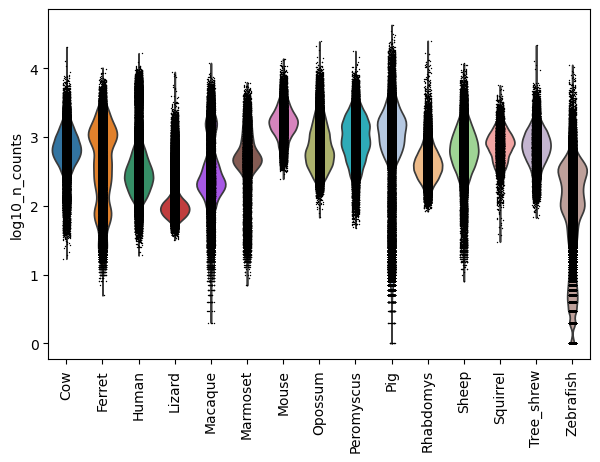

In [133]:
sc.pl.violin(bdata,groupby='species',keys=['log10_n_counts'],rotation=90)

In [136]:
cutoff_dict={'Human': 2.,
 'Macaque': 2.,
 'Zebrafish': 2.,
 'Lizard': 1.6,
 'Cow': 2.4,
 'Opossum': 2.,
 'Pig': 2.5,
 'Tree_shrew': 2.,
 'Sheep': 2.1,
 'Rhabdomys': 2.,
 'Ferret': 2.1,
 'Marmoset': 2.2,
 'Peromyscus': 2.,
 'Mouse': 2.,
 'Squirrel': 2.4}


In [143]:
bdata.obs['filter']=False
for k in cutoff_dict.keys():
    bdata.obs.loc[(bdata.obs['species']==k)&(bdata.obs['log10_n_counts']<cutoff_dict[k]),'filter']=True

In [ ]:
bdata[~bdata.obs['filter'],:].write_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/shekar_retina/retina_filtered.h5ad')

In [149]:
bdata=sc.read_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/shekar_retina/retina_mammals.h5ad')

In [150]:
bdata.obs['species'].value_counts().to_dict()

{'Human': 271061,
 'Macaque': 234000,
 'Cow': 92649,
 'Opossum': 90328,
 'Pig': 88000,
 'Tree_shrew': 81902,
 'Sheep': 74111,
 'Rhabdomys': 69744,
 'Ferret': 64000,
 'Marmoset': 64000,
 'Peromyscus': 47167,
 'Mouse': 42750,
 'Squirrel': 23999}

In [151]:
bdata.obs['log10_n_counts']=np.log10(bdata.layers['UMIs'].sum(1))

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


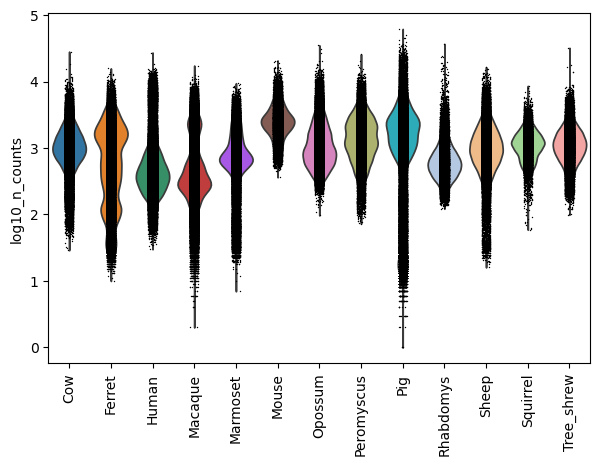

In [152]:
sc.pl.violin(bdata,groupby='species',keys=['log10_n_counts'],rotation=90)

In [155]:
cutoff_dict={'Human': 2.1,
 'Macaque': 2.,
 'Cow': 2.4,
 'Opossum': 2.5,
 'Pig': 2.6,
 'Tree_shrew': 2.5,
 'Sheep': 2.4,
 'Rhabdomys': 2.2,
 'Ferret': 2.4,
 'Marmoset': 2.4,
 'Peromyscus': 2.5,
 'Mouse': 2.5,
 'Squirrel': 2.5}


In [156]:
bdata.obs['filter']=False
for k in cutoff_dict.keys():
    bdata.obs.loc[(bdata.obs['species']==k)&(bdata.obs['log10_n_counts']<cutoff_dict[k]),'filter']=True

In [157]:
bdata.obs['filter'].mean()

0.06998169188822806

In [ ]:
bdata[~bdata.obs['filter'],:].write_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/shekar_retina/retina_mammals_filtered.h5ad')